First import required modules. Note that pandas and requests are not native libraries so may need to be installed first:

In [2]:
import json
import requests
import csv
from collections import defaultdict
from pandas import read_csv

Now define the endpoint and parameter vars:

In [3]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020091000'
                        }
mobile_web_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020091000'
                        }
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020091000'
                        }

Now define your header information (configure these with your own information):

In [4]:
user_agent = 'https://github.com/wframe-uw'
email_address = 'wframe@uw.edu'

Populate a headers variable with your info:

In [5]:
headers = {
    'User-Agent': user_agent,
    'From': email_address
}

Now define methods to make our api calls and save the responses: 

In [6]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response
def write_json(data, filename):
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)

Define file name variables to save our responses to: 

In [7]:
pagecounts_desktop_response_filename = 'pagecounts_desktop-site_200712-202008.json'
pagecounts_mobile_response_filename = 'pagecounts_mobile-site_200712-202008.json'
pageviews_desktop_response_filename = 'pageviews_desktop-site_201507-202008.json'
pageviews_mobile_web_response_filename = 'pageviews_mobile-web_201507-202008.json'
pageviews_mobile_app_response_filename = 'pageviews_mobile-app_201507-202008.json'

Now make our calls and save them to our files:

In [8]:
desktop_monthly_pagecounts = api_call(endpoint_legacy, desktop_params_legacy)
mobile_monthly_pagecounts = api_call(endpoint_legacy, mobile_params_legacy)
desktop_monthly_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)
mobile_web_monthly_pageviews = api_call(endpoint_pageviews, mobile_web_params_pageviews)
mobile_app_monthly_pageviews = api_call(endpoint_pageviews, mobile_app_params_pageviews)

write_json(desktop_monthly_pagecounts, pagecounts_desktop_response_filename)
write_json(mobile_monthly_pagecounts, pagecounts_mobile_response_filename)
write_json(desktop_monthly_pageviews, pageviews_desktop_response_filename)
write_json(mobile_web_monthly_pageviews, pageviews_mobile_web_response_filename)
write_json(mobile_app_monthly_pageviews, pageviews_mobile_app_response_filename)

Now let's write a method to aggregate our data over months and write it into a csv with our desired columns:

In [9]:
def consolidate_responses_into_csv(list_of_lists):
    # first flatten the lists into one
    flattened_list = [elem for inner in list_of_lists for elem in inner]
    
    # now make a timestamp keyed dict with lists of the various responses for that month
    date_keyed_response_dict = defaultdict(list)
    for dict in flattened_list:
        date_keyed_response_dict[dict['timestamp']].append(dict) 
    
    rows = []
    for date in date_keyed_response_dict:
        # make this month's row
        year_string = date[0:4]
        month_string = date[4:6]
        pagecount_all_views = 0
        pagecount_desktop_views = 0
        pagecount_mobile_views = 0
        pageview_all_views = 0
        pageview_desktop_views = 0
        pageview_mobile_views = 0
        for response in date_keyed_response_dict[date]:
            if 'access-site' in response and response['access-site'] == 'desktop-site':
                pagecount_desktop_views += int(response['count'])
                pagecount_all_views += int(response['count'])
            elif 'access-site' in response and response['access-site'] == 'mobile-site':
                pagecount_mobile_views += int(response['count'])
                pagecount_all_views += int(response['count'])
            elif 'access' in response and response['access'] == 'desktop':
                pageview_all_views += int(response['views'])
                pageview_desktop_views += int(response['views'])
            elif 'access' in response and response['access'] == 'mobile-app':
                pageview_all_views += int(response['views'])
                pageview_mobile_views += int(response['views'])
            elif 'access' in response and response['access'] == 'mobile-web':
                pageview_all_views += int(response['views'])
                pageview_mobile_views += int(response['views'])                
        row = [year_string, month_string, pagecount_all_views, pagecount_desktop_views, pagecount_mobile_views, pageview_all_views, pageview_desktop_views, pageview_mobile_views]        
        rows.append(row)    
    # write the rows
    with open('en-wikipedia_traffic_200712-202008.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["year", "month", "pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views", "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"])
        writer.writerows(rows)

Now let's call our above method with a list of our responses' items:

In [10]:
list_of_lists = [desktop_monthly_pagecounts['items'], mobile_monthly_pagecounts['items'], desktop_monthly_pageviews['items'], mobile_web_monthly_pageviews['items'], mobile_app_monthly_pageviews['items']]
consolidate_responses_into_csv(list_of_lists)

Now we read back our csv's content and plot it: 

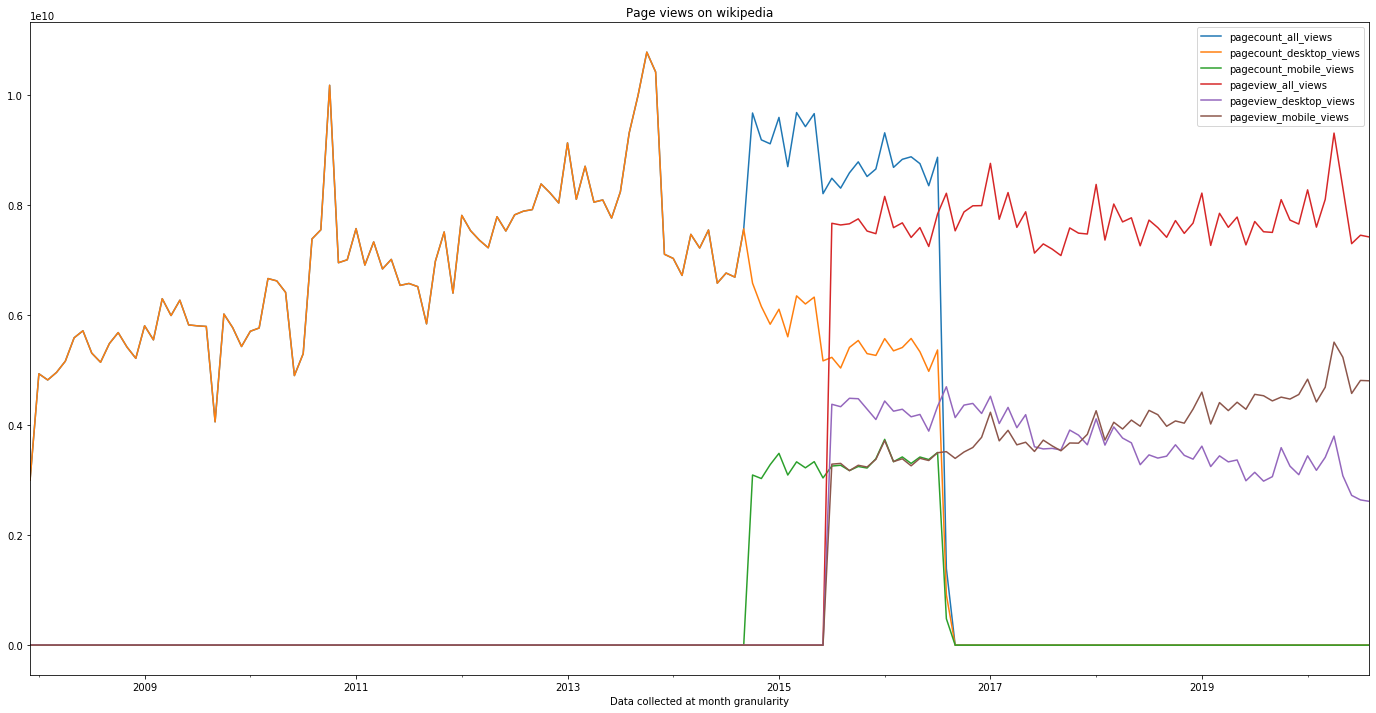

In [22]:
df = read_csv('en-wikipedia_traffic_200712-202008.csv', header=0, index_col=0, parse_dates=[[0,1]])
df.index.name = "Data collected at month granularity"
plot = df.plot(title="Page views on wikipedia", figsize=(24, 12)).get_figure()
plot.savefig(fname="WikipediaPageViews.png")